# Metropolis on alanine dipeptide with random intialization

**Anirudh Ghantasala, Datta Group, Purdue University**  
Last updated: 3-17-21  

1. Define the user parameters (timesteps, desired outputs)
2. Define a proposal distribution for particles based on the current state
3. Run simulation 


In [81]:
# user parameters ---------------------------------------------------
timesteps = 100
plot_distance_energy = True
download_movie = True
#--------------------------------------------------------------------

In [82]:
# Proposal Class, implements some logic that proposes a next state based on the current state (initial_positions)
class AddGaussianVector(mcmc.MetropolizedMove):
    def __init__(self, **kwargs):
        super(AddGaussianVector, self).__init__(**kwargs)

    def _propose_positions(self, initial_positions):
        # displacement = unit.Quantity(np.array([1, 1, 1]), initial_positions.unit)
        mean, var = 0, .1
        x_prop, y_prop, z_prop = np.random.normal(mean, var), np.random.normal(mean, var), np.random.normal(mean, var)
        displacement = unit.Quantity(np.array([x_prop, y_prop, z_prop]), initial_positions.unit)
        return initial_positions + displacement


TOTAL PARTICLES:  22
accepted 352/2200: 


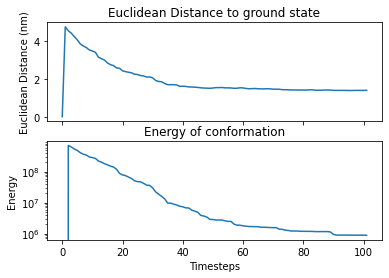

Simulation Complete!


In [83]:
from openmmtools import mcmc, testsystems, states, cache
from simtk import openmm
from simtk import unit
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import mdtraj as md


def distance(x, correct):
    for k in range(3):
        x[:, k] -= np.mean(x[:, k])
        correct[:, k] -= np.mean(correct[:, k])
    noise = np.subtract(x, correct)
    return np.sqrt(np.sum(np.square(noise)))

# platform = openmm.Platform.getPlatformByName('CUDA')
# cache.global_context_cache.platform = platform

# Create the initial state (thermodynamic and microscopic) for an alanine dipeptide system in vacuum.
alanine = testsystems.AlanineDipeptideVacuum(constraints=None)
sampler_state = states.SamplerState(alanine.positions)
thermodynamic_state = states.ThermodynamicState(alanine.system, 1 * unit.kelvin)
e, d, trajectory = [], [], []
context_cache = cache.global_context_cache
context, unused_integrator = context_cache.get_context(thermodynamic_state)
sampler_state.apply_to_context(context)

# initialize energy, distance, and trajectory
e.append(thermodynamic_state.reduced_potential(context))
d.append(distance(sampler_state.positions, sampler_state.positions))
trajectory.append(sampler_state.positions.copy())

# shift mean of molecule to 0,0,0
for k in range(3):
    sampler_state.positions[:, k] -= np.mean(sampler_state.positions[:, k])
sampler_state.apply_to_context(context, ignore_velocities=True)



# Add perterbance to correct state
noise = np.zeros((sampler_state.n_particles, 3))
correct_state = sampler_state.positions.copy()
for i, molecule in enumerate(sampler_state.positions):

    noise_low, noise_high = -1, 1
    sampler_state.positions[i][0] += unit.quantity.Quantity(value= np.random.uniform(noise_low, noise_high), unit=unit.nanometer)
    sampler_state.positions[i][1] += unit.quantity.Quantity(value= np.random.uniform(noise_low, noise_high), unit=unit.nanometer)
    sampler_state.positions[i][2] += unit.quantity.Quantity(value= np.random.uniform(noise_low, noise_high), unit=unit.nanometer)


sampler_state.apply_to_context(context)
e.append(thermodynamic_state.reduced_potential(context))
d.append(distance(sampler_state.positions.copy(), correct_state))
trajectory.append(sampler_state.positions.copy())


# Create an update MCMC move that brings us back to the initial configuration.
current_state = sampler_state.positions.copy()
total_accepted, total_proposed = 0, 0

print('TOTAL PARTICLES: ', sampler_state.n_particles)
for ii in range(timesteps):
    for jj in range(sampler_state.n_particles):
        move = AddGaussianVector(atom_subset=[jj])
        move.apply(thermodynamic_state, sampler_state)
        if move.n_accepted == 1:
            total_accepted += 1
        total_proposed += 1

    # measure euclidean distance
    current_state = sampler_state.positions.copy()
    d.append(distance(current_state, correct_state))

    # measure energy
    sampler_state.apply_to_context(context, ignore_velocities=True)
    e.append(thermodynamic_state.reduced_potential(context))

    # build trajectory
    trajectory.append(current_state)


# statistics and diagrams

print('accepted {}/{}: '.format(total_accepted, total_proposed))



if draw_init_final_positions:
    plt.figure(2)
    ax2 = plt.axes(projection='3d')
    xdata = sampler_state.positions[:, 0]
    ydata = sampler_state.positions[:, 1]
    zdata = sampler_state.positions[:, 2]
    ax2.scatter3D(xdata, ydata, zdata, cmap='Greens')
    plt.title('Final particle conformation')

if plot_distance_energy:

    fig, ((ax1),(ax2)) = plt.subplots(2, 1, sharex=True)
    ax1.plot(d, label='Euclidean dist')
    ax1.set_title('Euclidean Distance to ground state')
    ax1.set_ylabel('Euclidean Distance (nm)')
    ax2.plot(e, label='Energy')
    ax2.set_yscale('log')
    ax2.set_title('Energy of conformation')
    ax2.set_xlabel('Timesteps')
    ax2.set_ylabel('Energy')
    # ax2.text(2, 10, r'Original Energy {}'.format(e[0]), fontsize=15)




plt.show()
print('Simulation Complete!')

In [86]:
# if draw_ngl:
traj = md.Trajectory(trajectory, topology=alanine.mdtraj_topology)
traj.save('trajectory_alanine_dipeptide.pdb')
# traj.superimpose(trajectory, frame=0)
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=101)

In [78]:
# uncomment to select frame, reflects in above view
# view.frame = 0

In [77]:
# download 
# code for this cell: https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_movie/index.html
import moviepy.editor as mpy

from time import sleep


for frame in range(0, timesteps):
    # set frame to update coordinates
    view.frame = frame
    # make sure to let NGL spending enough time to update coordinates
    # sleep(0.5)
    view.download_image(filename='0image{}.png'.format(frame))
    # make sure to let NGL spending enough time to render before going to next frame
    sleep(2.0)

# end download code
# begin stitching-into-gif code
    
# In my case, my default download folder is /Users/haichit/Downloads/
template = '/Users/alasg/Downloads/0image{}.png'

# get all (sorted) image files
imagefiles = [template.format(str(i)) for i in range(0, timesteps, 1)]

frames_per_second = 8
im = mpy.ImageSequenceClip(imagefiles, fps=frames_per_second)
im.write_gif('my_movie.gif', fps=frames_per_second)
# im.write_videofile('my_movie.mp4', fps=frame_per_second)
from IPython import display

display.HTML("<img src='my_movie.gif'></img>")


[MoviePy] Building file my_movie.gif with imageio


 99%|█████████▉| 100/101 [00:14<00:00,  6.90it/s]


In [59]:
from nglview.contrib.movie import MovieMaker
movie = MovieMaker(view, download_folder='/Users/alasg/Downloads/', output='my.gif', in_memory=True)
movie.make()

IntProgress(value=0, description='Rendering ...', max=51)

In [40]:
# from nglview.contrib.movie import MovieMaker
# moviepy_params = {
#     'codec': 'mpeg4'
# }
# movie = MovieMaker(view, output='my.avi', in_memory=False, moviepy_params=moviepy_params)
# movie.make()

IntProgress(value=0, description='Rendering ...', max=101)

In [33]:
# JUST TO TEST NGLVIEW INSTALLATION
# import nglview as ngl

# view = nv.show_file(nv.datafiles.ALA3)
# view